# Extracting training data from the ODC



## Background

**Training data** is the most important part of any supervised machine learning workflow. The quality of the training data has a greater impact on the classification than the algorithm used. Large and accurate training data sets are preferable: increasing the training sample size results in increased classification accuracy ([Maxell et al 2018](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343)).  A review of training data methods in the context of Earth Observation is available [here](https://www.mdpi.com/2072-4292/12/6/1034) 

When creating training labels, be sure to capture the **spectral variability** of the class, and to use imagery from the time period you want to classify (rather than relying on basemap composites). Another common problem with training data is **class imbalance**. This can occur when one of your classes is relatively rare and therefore the rare class will comprise a smaller proportion of the training set. When imbalanced data is used, it is common that the final classification will under-predict less abundant classes relative to their true proportion.

There are many platforms to use for gathering training labels, the best one to use depends on your application. GIS platforms are great for collection training data as they are highly flexible and mature platforms; [Geo-Wiki](https://www.geo-wiki.org/) and [Collect Earth Online](https://collect.earth/home) are two open-source websites that may also be useful depending on the reference data strategy employed. Alternatively, there are many pre-existing training datasets on the web that may be useful, e.g. [Radiant Earth](https://www.radiant.earth/) manages a growing number of reference datasets for use by anyone.


## Description
This notebook will extract training data (feature layers) from the `open-data-cube` using geometries within a geojson. The default example will use the crop/non-crop labels within the `'data/jeca.geojson'` file. 



## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [2]:
%matplotlib inline

import os
import shapely
import botocore
import datacube
import numpy as np
import xarray as xr
import subprocess as sp
import geopandas as gpd
from odc.io.cgroups import get_cpu_quota
from datacube.utils.geometry import assign_crs

from deafrica_tools.plotting import map_shapefile
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import collect_training_data

import warnings
warnings.filterwarnings("ignore")

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [1]:
#pip install Shapely==1.2b6

In [3]:
#pip install -U "aiobotocore[awscli,boto3]==1.3.3"

## Analysis parameters

* `path`: The path to the input vector file from which we will extract training data. A default geojson is provided.
* `field`: This is the name of column in your shapefile attribute table that contains the class labels. **The class labels must be integers**


In [3]:
#kofa = gpd.read_file('data/Kofa_reduced/Kofa_reduced.shp')
#print(type(kofa))
#kofa
kofa = gpd.read_file('../kofa_data/1564_ICRISAT-Kofa_aoi.shp')

In [5]:
kofa.columns

Index(['FID', 'geometry'], dtype='object')

In [15]:
import numpy as np
from osgeo import gdal, gdal_array
import pandas as pd
import operator
import gc
import os

roi_ds = gdal.Open('../kofa_data/2015_sept/15SEP12100551-P2AS_R1C1-054205021180_01_P0011sub.tif', gdal.GA_ReadOnly)

#train_ds = gdal.Open('D:/neurafarms/downloaded_sat_images/rose_mlready/0306.tiff', gdal.GA_ReadOnly)

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(roi)


# Iterate over all class labels in the ROI image, printing out some information
#for c in classes:
  #  print('Class {c} contains {n} pixels'.format(c=c,
#n=(roi == c).sum()))

In [14]:
dict = {}
for c in classes:
    dict[c] = (roi == c).sum()
sorted_x = sorted(dict.items(), key=operator.itemgetter(1))
print("Top 6 classes and pixel counts \n",sorted_x[-6:])

Top 6 classes and pixel counts 
 [(406, 44218), (409, 44283), (408, 44310), (407, 44324), (405, 44430), (65536, 49665)]


In [7]:
roi

array([[65536, 65536, 65536, ..., 65536, 65536, 65536],
       [65536, 65536, 65536, ..., 65536, 65536, 65536],
       [65536, 65536, 65536, ..., 65536, 65536, 65536],
       ...,
       [65536, 65536, 65536, ..., 65536, 65536, 65536],
       [65536, 65536, 65536, ..., 65536, 65536, 65536],
       [65536, 65536, 65536, ..., 65536, 65536, 65536]], dtype=uint32)

### Find the number of CPUs

In [6]:

ncpus=round(get_cpu_quota())
print('ncpus = '+str(ncpus))

ncpus = 4


In [8]:
# Plot training data in an interactive map
import matplotlib.pyplot as plt
field ='FID'
map_shapefile(kofa, attribute=field)
#plt.savefig('kofa.png')

Label(value='')

Map(center=[11.55539992970925, 8.26788000000002], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

## Preview input data

We can load and preview our input data shapefile using `geopandas`. The shapefile should contain a column with class labels (e.g. 'class'). These labels will be used to train our model. 

> Remember, the class labels **must** be represented by `integers`.


## For data extracted directly from the geojson

In [28]:
#Reducing some columns though for this analysis only.
input_data = input_data.drop(['Object_ID', 'SupObject_ID', 'State_Object', 'Agent', 'Date_created',
       'Location_name', 'Access_mode', 'Loan_type', 'Document',
       'Occupation_duration', 'Lon_lat', 'Circumference', 'Azimuth_of',
       'Position2', 'Land_cover', 'Crop_group', 'Crop_class', 'Sub_class',
       'Other_crop', 'Farm_area', 'Tillage', 'Residues', 'Grain_vs_fodder',
       'Water_source', 'Pure/Mixed_crop', 'FlagGeom', 'Area_ha',],axis=1)

In [35]:
input_data = input_data[['Grown_crops','geometry']]


In [36]:
input_data.head()

,Grown_crops,geometry
0,0,"MULTIPOLYGON (((8.25969 11.55618, 8.26104 11.5..."
2,0,"MULTIPOLYGON (((8.25797 11.55537, 8.25812 11.5..."
3,0,"MULTIPOLYGON (((8.25751 11.55499, 8.25773 11.5..."
6,0,"MULTIPOLYGON (((8.25865 11.55405, 8.25850 11.5..."
8,0,"MULTIPOLYGON (((8.26029 11.55414, 8.26002 11.5..."


In [34]:
#save the Geojson of the selinpuected crops
input_data.to_file('data/kofa_reduced.geojson',driver='GeoJSON')

#save the shapefile, cpg of the selected crops
input_data.to_file('data/Kofa_reduced.geojson')

In [20]:
#read data from the tiles from the world view images
import pandas as pd
data = pd.read_csv('data/kofa_edited.csv')
#data.head()

## Matching the GT data with the Imagery data

In [5]:
kofa = gpd.read_file('data/Kofa_reduced/Kofa_reduced.shp')
#print(type(kofa))

In [6]:
kofa.head()

,Grown_crop,geometry
0,0,"POLYGON ((8.25969 11.55618, 8.26104 11.55557, ..."
1,0,"POLYGON ((8.25797 11.55537, 8.25812 11.55494, ..."
2,0,"POLYGON ((8.25751 11.55499, 8.25773 11.55511, ..."
3,0,"POLYGON ((8.25865 11.55405, 8.25850 11.55493, ..."
4,0,"POLYGON ((8.26029 11.55414, 8.26002 11.55456, ..."


## select plots

In [7]:
#Determine the plots which are multipolygons
multip = []
for i in range(len(kofa)):
    if kofa.geometry[i].geom_type == 'MultiPolygon':
        multip.append(i)
multip

[21, 250, 258, 266, 510, 783, 1742, 1743]

In [8]:
kofa.Grown_crop.value_counts()

1    1369
0     320
3     156
2      87
4      70
Name: Grown_crop, dtype: int64

(array([ 320.,    0., 1369.,    0.,    0.,   87.,    0.,  156.,    0.,
          70.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

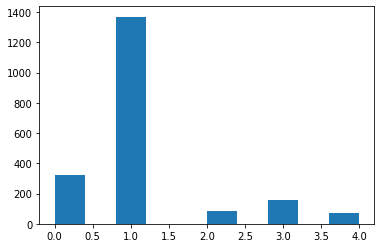

In [12]:
import matplotlib.pyplot as plt
counts, bins = np.histogram(kofa.Grown_crop)
plt.hist(bins[:-1], bins, weights=counts,le)

## Solving Classes Imbalance

In [9]:
import pandas as pd
#create more coordinates within the plots 
def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

def polygon_gridding(plot_id = 10,n =20):
    ticks = []

    polygon = list(zip(list(kofa.geometry[plot_id].exterior.xy[0]),list(kofa.geometry[plot_id].exterior.xy[1])))
    #n  number of parts on each side of the grid

    # we first find ticks on each side of the polygon
    for j in range(len(polygon)):  # because we are talking about 4-gons
        temp_ticks = []
        for i in range(n-1):
            t = (i+1)*(1/n)
            Ex = polygon[j][0] * (1-t) + polygon[(j+1) % 4][0] * t
            Ey = polygon[j][1] * (1-t) + polygon[(j+1) % 4][1] * t
            temp_ticks.append((Ex, Ey))
        if j < 2:
            ticks.append(temp_ticks)
        else: # because you are moving backward in this part
            temp_ticks.reverse()
            ticks.append(temp_ticks)

    # then we find lines of the grid
    h_lines = []
    v_lines = []
    for i in range(n-1):
        h_lines.append((ticks[0][i], ticks[2][i]))
        v_lines.append((ticks[1][i], ticks[3][i]))

    # then we find the intersection of grid lines
    l_list_x = []
    l_list_y = []
    for i in range(len(h_lines)):
        for j in range(len(v_lines)):
            line1 = h_lines[i]
            line2 = v_lines[j]
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
            div = det(xdiff, ydiff)
            if div == 0:
                raise Exception('lines do not intersect')

            d = (det(*line1), det(*line2))
            x = det(d, xdiff) / div
            y = det(d, ydiff) / div
            l_list_x.append(x)
            l_list_y.append(y)
    return l_list_x,l_list_y
       
        


ERROR  ----DROP THIS MULTIPOLYGONS (ROWS)
[21, 250, 258, 266, 510, 783, 1742, 1743]


In [10]:
#Take the polygons and exclude multipolygons
valid_polygons = list(set(list(range(len(kofa)))) - set([21, 250, 258, 266, 510, 783, 1742, 1743]))

#Map the extracted coordinates with the respective grown crops and create a dataframe
df1 = pd.DataFrame()
for i in valid_polygons:
    result = polygon_gridding(plot_id = i,n =30)
    df = pd.DataFrame()
    df['lon'] = result[0]
    df['lat'] = result[1]
    df['Grown_crop'] = kofa.Grown_crop[i]
    df1 = df1.append(df)
df1.shape

(1676954, 3)

In [11]:
 df['lon'][0]

8.286911381767199

In [93]:
#save the dataframes as a csv file
df1.to_csv("data/More_GT_data.csv", index = False)

In [94]:
df1.Grown_crop.value_counts()

1    1146283
0     268279
3     131196
2      72326
4      58870
Name: Grown_crop, dtype: int64

(array([ 268279.,       0., 1146283.,       0.,       0.,   72326.,
              0.,  131196.,       0.,   58870.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

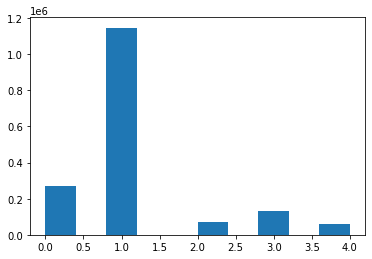

In [95]:
import matplotlib.pyplot as plt
counts, bins = np.histogram(df1.Grown_crop)
plt.hist(bins[:-1], bins, weights=counts)
plt,

In [96]:
#for worldview images
data = pd.read_csv('data/full_data.csv')

In [12]:
#for landsat images
data = pd.read_csv('data/landsat_data.csv')

In [13]:
data.head()

,red,green,blue,nir,swir_1,swir_2,pixel_quality,qa_aerosol,lon,lat
0,9986.0,9725.0,9379.0,9301.0,10227.0,11692.0,10199.0,9862.0,8.234328,11.578069
1,10527.0,9944.0,9518.0,9788.0,10112.0,10272.0,10458.0,9809.0,8.234604,11.578070
2,9576.0,10078.0,10049.0,9884.0,9786.0,10305.0,9990.0,9566.0,8.234879,11.578071
3,9486.0,9571.0,10581.0,10496.0,9680.0,9510.0,9491.0,9471.0,8.235154,11.578071
4,10055.0,10196.0,10074.0,10379.0,10317.0,10050.0,10716.0,10538.0,8.235429,11.578072


In [14]:
data['lon'][0]

8.234328363552438

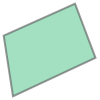

In [15]:
kofa.geometry[10]


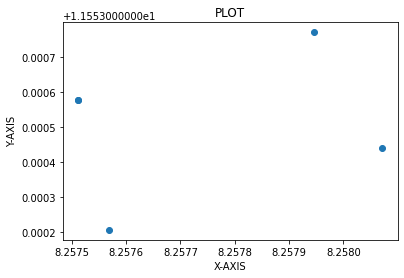

In [128]:
l_list_x1 =  list(kofa.geometry[10].exterior.xy[0])
l_list_y1  =  list(kofa.geometry[10].exterior.xy[1])
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
fig, ax = plt.subplots()
ax.scatter(l_list_x1,l_list_y1)

plt.xlabel("X-AXIS")
plt.ylabel("Y-AXIS")
plt.title("PLOT")
#plt.show()
plt.savefig('data/plot101.png')

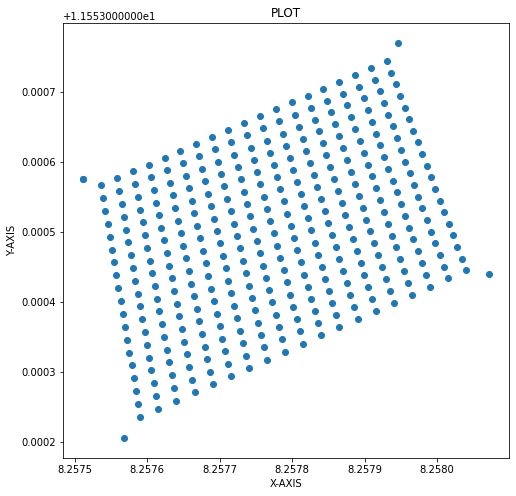

In [127]:
l_list_x = polygon_gridding()[0] + list(kofa.geometry[10].exterior.xy[0])
l_list_y  = polygon_gridding()[1] + list(kofa.geometry[10].exterior.xy[1])
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(l_list_x,l_list_y)

plt.xlabel("X-AXIS")
plt.ylabel("Y-AXIS")
plt.title("PLOT")
#plt.show()
plt.savefig('data/plot10.png')

In [16]:
#Truncate the lon and lat to extract data. Do for both data sets
#change to labeldata after data
lon =[]
lat = []
def truncate(num):
    return int(num * 100000) / 100000
for i in df1.lon:
    i = float(i)
    i =truncate(i)
    lon.append(i)
    
for j in df1.lat:
    j = float(j)
    j =truncate(j)
    lat.append(j)
    
df1['lon'] = lon
df1['lat'] = lat


In [17]:
lon =[]
lat = []
def truncate(num):
    return int(num * 100000) / 100000
for i in data.lon:
    i = float(i)
    i =truncate(i)
    lon.append(i)
    
for j in data.lat:
    j = float(j)
    j =truncate(j)
    lat.append(j)
    
data['lon'] = lon
data['lat'] = lat


In [18]:
df1['lon'][0]

0    8.25985
0    8.25796
0    8.25752
0    8.25864
0    8.26028
      ...   
0    8.28754
0    8.28748
0    8.28753
0    8.28713
0    8.28691
Name: lon, Length: 1994, dtype: float64

In [23]:
data.shape

(31570, 10)

In [26]:
result = pd.merge(data, df1, how ='inner', on=['lat','lon'])

In [27]:
result.shape

(2262, 11)

In [28]:
result.Grown_crop.value_counts()

1    1519
0     428
3     146
2      89
4      80
Name: Grown_crop, dtype: int64

In [29]:
result.to_csv('data/Clean_landsatkofadata.csv', index= False)

In [30]:
data = pd.read_csv('data/Clean_landsatkofadata.csv', )

In [31]:
data.head()

,red,green,blue,nir,swir_1,swir_2,pixel_quality,qa_aerosol,lon,lat,Grown_crop
0,9693.0,10337.0,10304.0,10395.0,10105.0,10692.0,10578.0,10087.0,8.26019,11.57705,1
1,9693.0,10337.0,10304.0,10395.0,10105.0,10692.0,10578.0,10087.0,8.26019,11.57705,1
2,9693.0,10337.0,10304.0,10395.0,10105.0,10692.0,10578.0,10087.0,8.26019,11.57705,1
3,10169.0,9797.0,10304.0,10932.0,10805.0,10824.0,10076.0,9465.0,8.26157,11.57678,1
4,9684.0,9497.0,9708.0,9648.0,9529.0,9394.0,9543.0,9540.0,8.25304,11.57649,1


## Landsat 8 data

In [52]:
data.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'lon', 'lat',
       'Grown_crop'],
      dtype='object')

In [4]:
path = 'data/kofa_reduced.geojson' 
field = 'Grown_crops'

In [5]:
# Load input data shapefile
input_data = gpd.read_file(path)

In [6]:
# Plot training data in an interactive map
import matplotlib.pyplot as plt
map_shapefile(input_data, attribute=field)
#plt.savefig('data/Kofa_reduced.png')

Label(value='')

Map(center=[11.55734130636384, 8.262466732308093], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Now let's run the `collect_training_data` function.

> **Note**: With supervised classification, its common to have many, many labelled geometries in the training data. `collect_training_data` can parallelize across the geometries in order to speed up the extracting of training data. Setting `ncpus>1` will automatically trigger the parallelization. However, its best to set `ncpus=1` to begin with to assist with debugging before triggering the parallelization.  You can also limit the number of polygons to run when checking code. For example, passing in `gdf=input_data[0:5]` will only run the code over the first 5 polygons.

## Recommended next steps

To continue working through the notebooks in this `Scalable Machine Learning on the ODC` workflow, go to the next notebook `2_Extracting_training_data.ipynb`.
1. **Pre_processing_data (this notebook)**
2. [Extracting_training_data](2_Extracting_training_data.ipynb)
3. [Inspect_training_data](3_Inspect_training_data.ipynb)
4. [Evaluate_optimize_fit_classifier](4_Evaluate_optimize_fit_classifier.ipynb)
5. [Classify_satellite_data](5_Classify_satellite_data.ipynb)
6. [Object-based_filtering](6_Object-based_filtering.ipynb)


In [ ]:
im = cv2.imread()